In [1]:
import datetime
import time
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
from scipy.optimize import curve_fit

from jupyterthemes import jtplot
jtplot.style(theme='onedork')

import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (16,6)

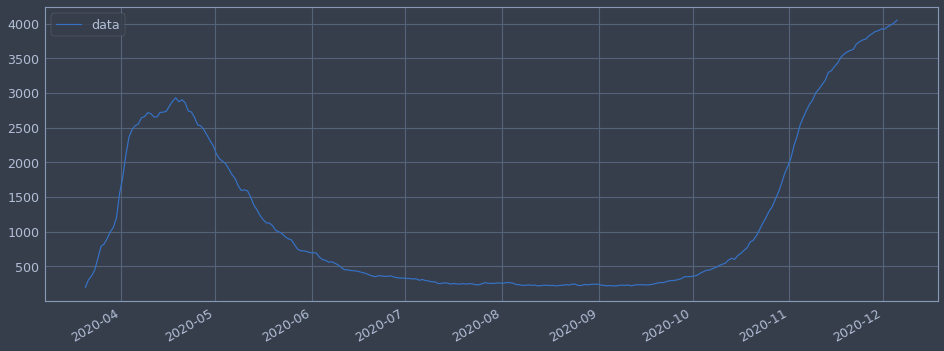

In [2]:
# data-source: https://datawrapper.dwcdn.net/WvhXR/

df_raw = pd.read_csv('data-WvhXR.csv', index_col=0, names=['data'], header = 0)
df_raw.index = pd.to_datetime(df_raw.index, utc=True)
df_raw.plot()

In [3]:
def gaussian(x, sat, td, velo, offset):
    x = np.float64(x) / 1e18
    sat *= 1e4
    offset *= 1e4
    velo /=1e2

    return (sat * np.exp(-(x-td)**2/(2*velo**2))) + offset

<ipython-input-4-05e106c38f23>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_fit['fit'] = gaussian(df_fit.index, *list(popt))
<ipython-input-4-05e106c38f23>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_fit['res'] = df_fit.data - df_fit.fit


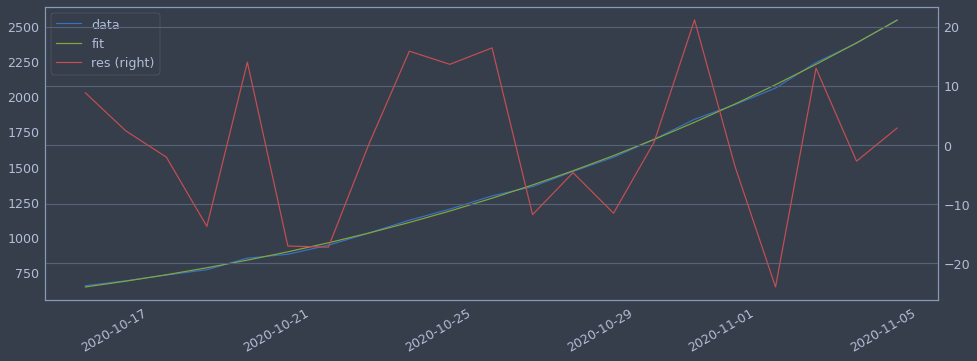

In [4]:
fit_start = '2020-10-15'
fit_end = '2020-11-04'

df_fit = df_raw[fit_start:fit_end]

popt, pcov = curve_fit(
    f = gaussian,
    xdata = df_fit.index,
    ydata = df_fit.data,
    p0 = (1, 1.61, .3, 1)
)

df_fit['fit'] = gaussian(df_fit.index, *list(popt))
df_fit['res'] = df_fit.data - df_fit.fit

df_fit.plot(secondary_y="res")

In [5]:
maxdate = datetime.datetime.fromtimestamp(popt[1] * 1e9, tz=df_fit.index.tz)
maxdate.strftime("%Y-%B-%d %H:%M")

'2020-December-12 07:40'

In [6]:
int(popt[3] * 1e4)

291

In [7]:
int(popt[0] * 1e4 + popt[3] * 1e4)

9246

In [8]:
sigma = datetime.timedelta(seconds=(popt[2] / 1e2) * 1e9)
sigma

datetime.timedelta(days=22, seconds=67182, microseconds=471606)

In [9]:
maxdate - sigma

datetime.datetime(2020, 11, 19, 13, 0, 40, 157170, tzinfo=<UTC>)

In [10]:
ix_extrapol = pd.date_range(df_fit.index[0], df_fit.index[0] + 2 *  (maxdate - df_fit.index[0]))

In [11]:
uneffected = df_raw[fit_start:fit_end].data#.plot()
uneffected.index = uneffected.index.date
uneffected.name = 'uneffected'

effected = df_raw[fit_end:].data#.plot()
effected.index = effected.index.date
effected.name = 'effected'

extrapolation_uneff = pd.Series(gaussian(ix_extrapol, *list(popt)), index=ix_extrapol)#.plot(style=':')
extrapolation_uneff.index = extrapolation_uneff.index.date
extrapolation_uneff.name = 'extrapolation_uneff'

<ipython-input-12-00358309c37d>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_fit2['fit'] = gaussian(df_fit2.index, *list(popt2))
<ipython-input-12-00358309c37d>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_fit2['res'] = df_fit2.data - df_fit2.fit


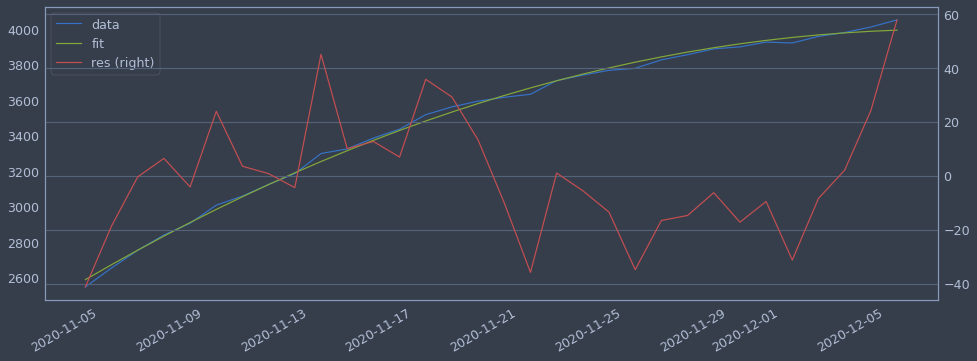

In [12]:
df_fit2 = df_raw[fit_end:]

popt2, pcov2 = curve_fit(
    f = gaussian,
    xdata = df_fit2.index,
    ydata = df_fit2.data,
    p0 = popt
)


df_fit2['fit'] = gaussian(df_fit2.index, *list(popt2))
df_fit2['res'] = df_fit2.data - df_fit2.fit

df_fit2.plot(secondary_y="res")

In [13]:
maxdate2 = datetime.datetime.fromtimestamp(popt2[1] * 1e9, tz=df_fit2.index.tz)
maxdate2.strftime("%Y-%B-%d %H:%M")

'2020-December-07 09:34'

In [14]:
int(popt2[0] * 1e4 + popt2[3] * 1e4)

3998

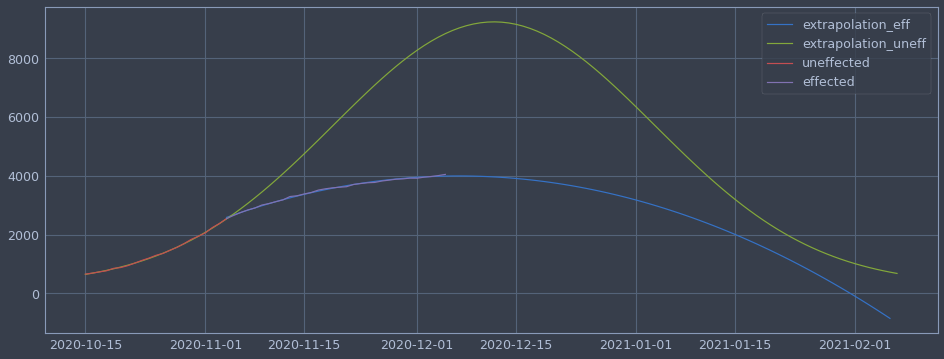

In [15]:
ix_extrapol2 = pd.date_range(df_fit2.index[0], max(df_fit2.index[0] + 2 *  (maxdate2 - df_fit2.index[0]), ix_extrapol[-1]))

extrapolation_eff = pd.Series(gaussian(ix_extrapol2, *list(popt2)), index=ix_extrapol2)#.plot(style=':')
extrapolation_eff.index = extrapolation_eff.index.date
extrapolation_eff.name = 'extrapolation_eff'

df_extra = pd.concat([extrapolation_eff,  extrapolation_uneff, uneffected, effected], axis=1)
df_extra.plot()